In [ ]:
%pip install pydiffmap

In [ ]:
import os
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pydiffmap import diffusion_map
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, fowlkes_mallows_score, silhouette_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from zipfile import ZipFile
file_name = '/content/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Functions for ML Models

In [ ]:
def generateSplit(features, label):
    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

def predict(model, X_test):
    pred = model.predict(X_test)

    return pred

def predict_with_scaling(scaler, model, X_test):
    X_test_scaled = scaler.transform(X_test)
    pred = model.predict(X_test_scaled)

    return pred

def scaleData(scaler, X_train):
    fit_scalar = scaler.fit(X_train)
    X_train_scaled = fit_scalar.transform(X_train)

    return X_train_scaled

def loadAndTrainModel(X_train, y_train, model_constructor, param_dict):
    model = model_constructor(**param_dict)

    model.fit(X_train, y_train)

    return model

# Function to Run ML Models

In [ ]:
def evaluateClassification(X_dict, y, model_constructor, param_dict = None, scaler = None):
  results_dict = {}

  for dataset_name, X in X_dict.items():
    # Do parameter tuning
    params = {}
    if param_dict != None:
      estimator = model_constructor()
      grid_search = GridSearchCV(estimator = estimator, param_grid = param_dict, cv = 2, scoring = "accuracy")

      if scaler == None:
        grid_search.fit(X, y)
      else:
        X_scaled = scaleData(scaler, X)
        grid_search.fit(X_scaled, y)

      best_params = grid_search.best_params_
      print(f"Best Parameters for {dataset_name}:", best_params)

      params = best_params

    X_train, X_test, y_train, y_test = generateSplit(X, y)

    # Check if scaling is necessary
    if scaler == None:
      model = loadAndTrainModel(X_train, y_train, model_constructor, params)

      y_pred = predict(model, X_test)
    else:
      X_train_scaled = scaleData(scaler, X_train)

      model = loadAndTrainModel(X_train_scaled, y_train, model_constructor, params)

      y_pred = predict_with_scaling(scaler, model, X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results_dict[dataset_name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1}

  return results_dict

# Function for Plotting th ML Model Results

In [ ]:
def PlotResult(results_dict, result_to_plot):
  keys = list(results_dict.keys())
  plotted_result = [results_dict[key][result_to_plot] for key in keys]

  # Create the plot
  plt.figure(figsize=(8, 6))
  plt.bar(keys, plotted_result)
  plt.xlabel('Models')
  plt.ylabel(result_to_plot)
  plt.title(f'{result_to_plot} of Different Models')
  plt.show()

# Data Preprocessing

In [ ]:
# Define the image dimensions
IMG_WIDTH, IMG_HEIGHT = 128, 128

# Define the path to the dataset
dataset_path = 'Dataset'

# Define a dictionary to map folder names to class labels
class_labels = {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}

# Function to load and preprocess images
def load_and_preprocess_images(dataset_path, img_width, img_height):
    images = []
    labels = []
    for class_name, class_label in class_labels.items():
        class_folder = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_width, img_height))
                images.append(img.flatten())
                labels.append(class_label)
    return np.array(images), np.array(labels)

# Load and preprocess the images
X, y = load_and_preprocess_images(dataset_path, IMG_WIDTH, IMG_HEIGHT)

# Print the shape of the processed data
print(f'Processed data shape: {X.shape}')
print(f'Processed labels shape: {y.shape}')

Processed data shape: (6400, 16384)
Processed labels shape: (6400,)


# Apply the NLDR techniques

In [ ]:
# Initialize ISOMAP with best parameters
isomap = Isomap(n_components = 44)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

X_dict = {"Isomap": X_isomap}

# Initialize LLE with best parameters
lle = LocallyLinearEmbedding(n_components = 1030, eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

X_dict["LLE"] = X_lle

# Initialize Diffusion Map
neighbor_params = {'algorithm': 'brute'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params, alpha = 0.25)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

X_dict["diffmap"] = X_diffmap

# Initialize t-SNE with best parameters for 2 dimensions
tsne2D = TSNE(n_components = 2, perplexity = 10, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne_2D = tsne2D.fit_transform(X)

X_dict["t-SNE 2D"] = X_tsne_2D

# Initialize t-SNE with best parameters for 3 dimensions
tsne3D = TSNE(n_components = 3, perplexity = 10, learning_rate = 100, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne_3D = tsne3D.fit_transform(X)

X_dict["t-SNE 3D"] = X_tsne_3D

# Logistic Regression

## Fit Model

In [ ]:
param_grid = {
    'C': [10, 50],
    'solver': ['saga'],
    'max_iter': [5_000, 10_000]
}

results_dict = evaluateClassification(X_dict, y, LogisticRegression, param_grid)

Best Parameters for Isomap: {'C': 10, 'max_iter': 5000, 'solver': 'saga'}
Best Parameters for LLE: {'C': 50, 'max_iter': 5000, 'solver': 'saga'}
Best Parameters for diffmap: {'C': 10, 'max_iter': 10000, 'solver': 'saga'}
Best Parameters for t-SNE 2D: {'C': 10, 'max_iter': 5000, 'solver': 'saga'}
Best Parameters for t-SNE 3D: {'C': 10, 'max_iter': 5000, 'solver': 'saga'}


## Plot Results

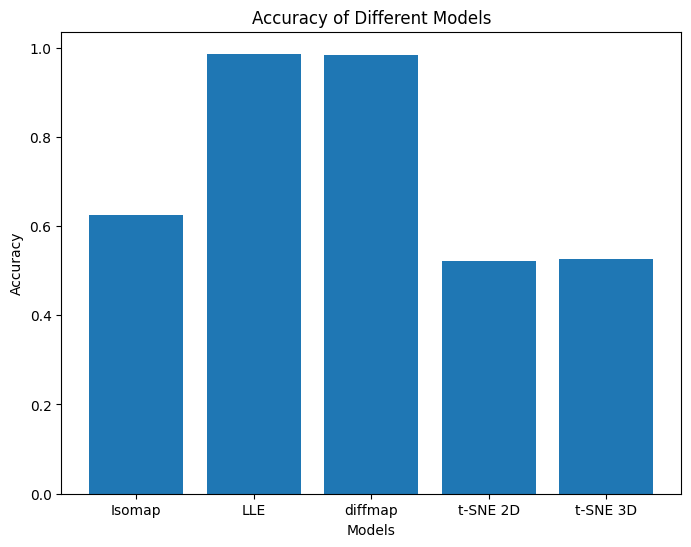

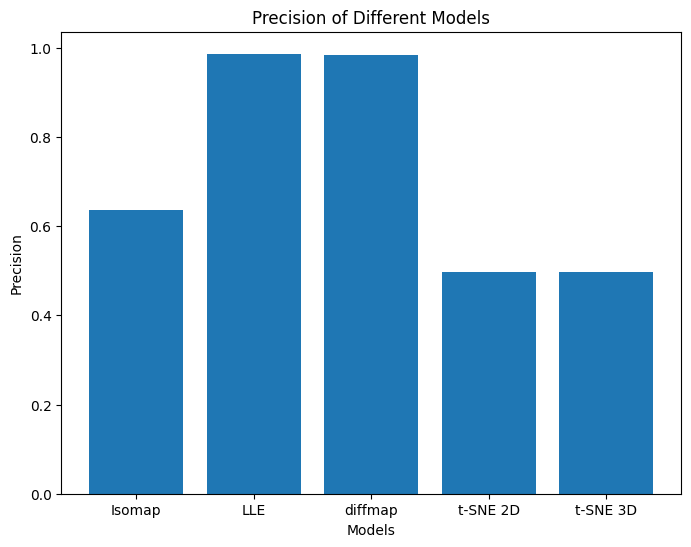

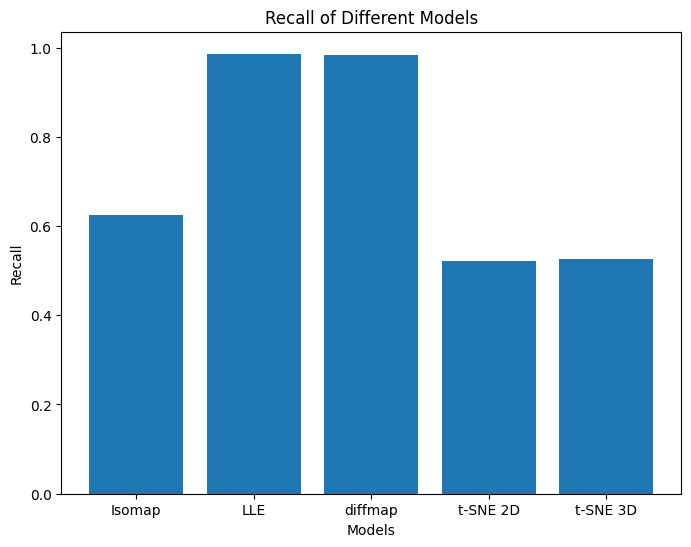

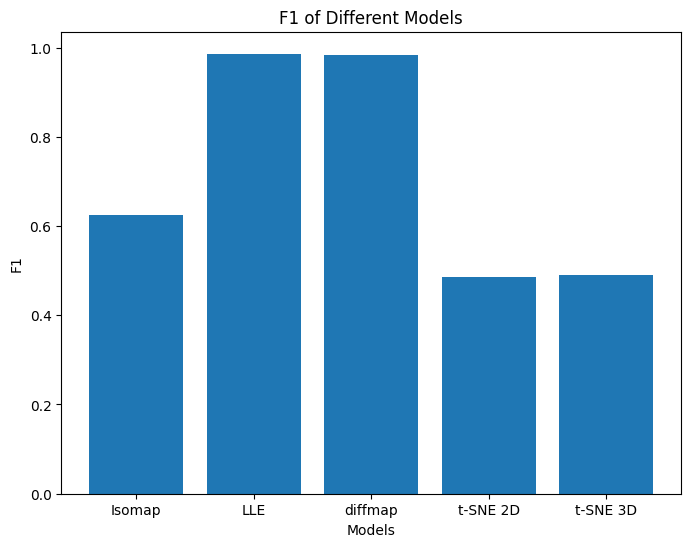

In [ ]:
for key in list(results_dict.values())[0].keys():
  PlotResult(results_dict, key)

## Print Results as Table

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(results_dict, orient='index')

print(df)

          Accuracy  Precision    Recall        F1
Isomap    0.625625   0.635632  0.625625  0.624433
LLE       0.986250   0.986378  0.986250  0.986206
diffmap   0.982500   0.983076  0.982500  0.982643
t-SNE 2D  0.520625   0.497015  0.520625  0.485557
t-SNE 3D  0.525625   0.497890  0.525625  0.489810


# SVM

## Fit Model

In [ ]:
param_grid = {
    'C': [10, 50],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

results_dict = evaluateClassification(X_dict, y, SVC, param_grid, MinMaxScaler())

Best Parameters for Isomap: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Best Parameters for LLE: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Parameters for diffmap: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Parameters for t-SNE 2D: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Best Parameters for t-SNE 3D: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}


## Plot Results

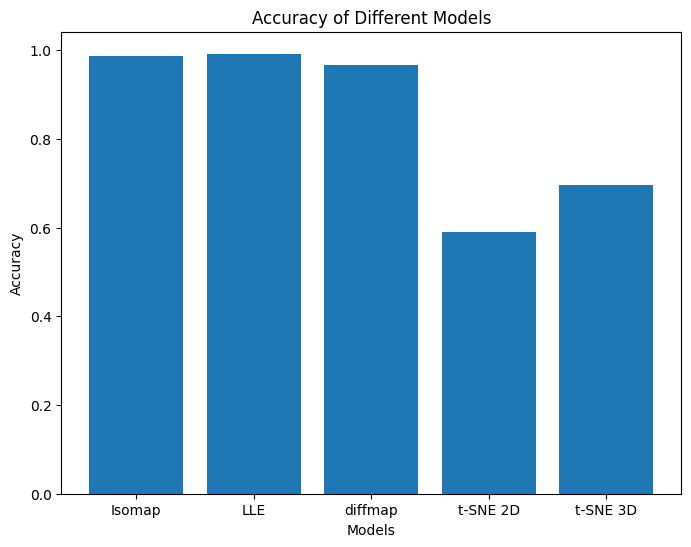

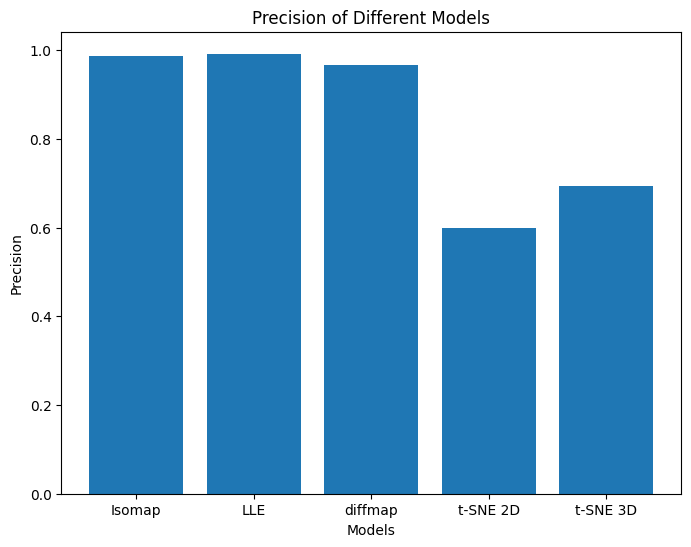

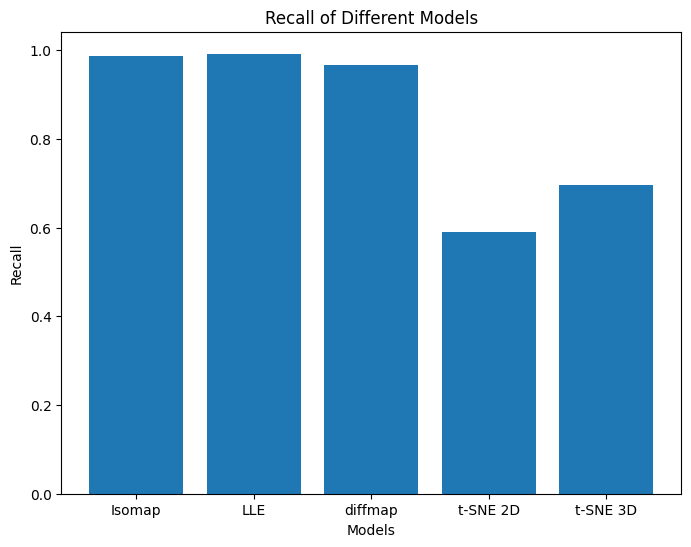

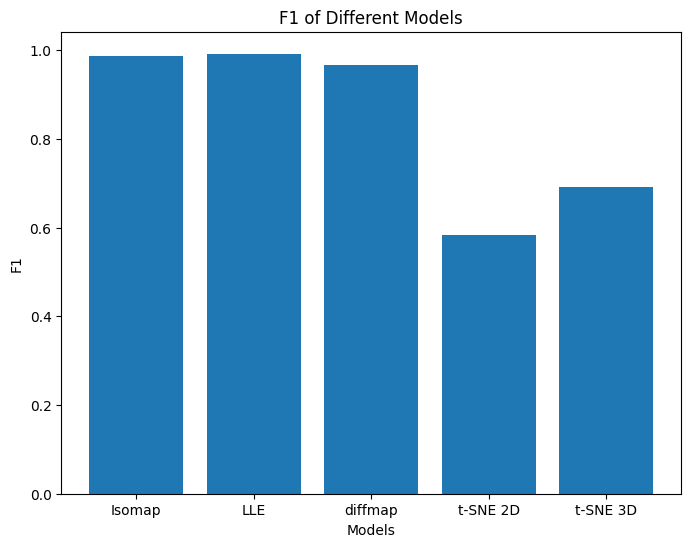

In [ ]:
for key in list(results_dict.values())[0].keys():
  PlotResult(results_dict, key)

## Print Results as Table

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(results_dict, orient='index')

print(df)

          Accuracy  Precision    Recall        F1
Isomap    0.985625   0.985676  0.985625  0.985631
LLE       0.991875   0.991912  0.991875  0.991860
diffmap   0.966875   0.967281  0.966875  0.966757
t-SNE 2D  0.589375   0.598888  0.589375  0.584201
t-SNE 3D  0.695000   0.693354  0.695000  0.692059


# Random Forest

## Fit Model

In [ ]:
param_grid = {
    'n_estimators': [300, 500],
    'criterion': ['gini', 'entropy', 'log_loss']
}

results_dict = evaluateClassification(X_dict, y, RandomForestClassifier, param_grid)

Best Parameters for Isomap: {'criterion': 'log_loss', 'n_estimators': 300}
Best Parameters for LLE: {'criterion': 'log_loss', 'n_estimators': 500}
Best Parameters for diffmap: {'criterion': 'log_loss', 'n_estimators': 500}
Best Parameters for t-SNE 2D: {'criterion': 'gini', 'n_estimators': 300}
Best Parameters for t-SNE 3D: {'criterion': 'log_loss', 'n_estimators': 500}


## Plot Results

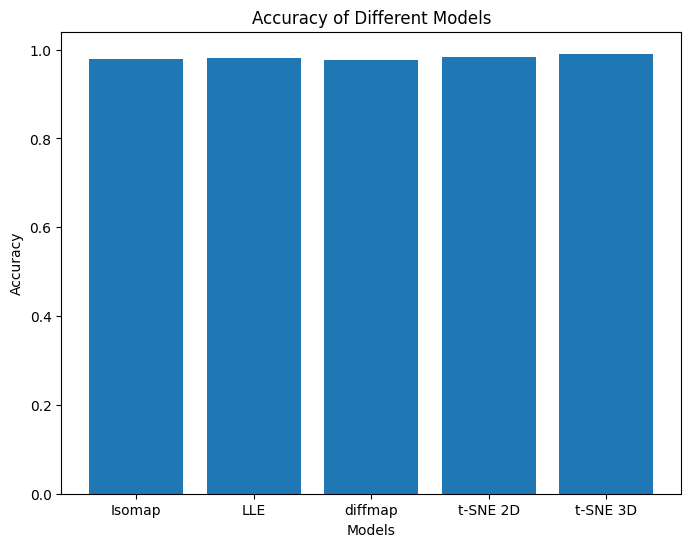

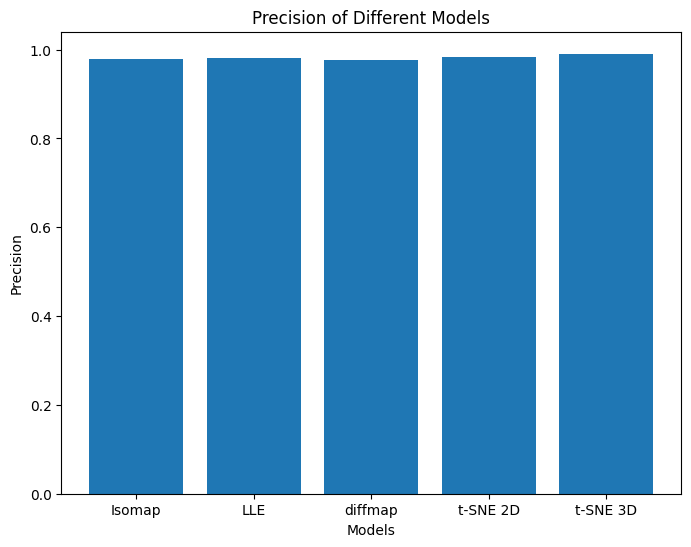

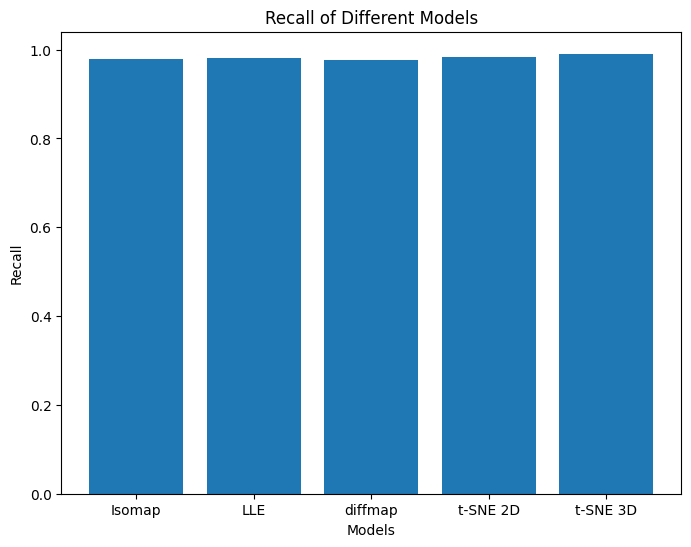

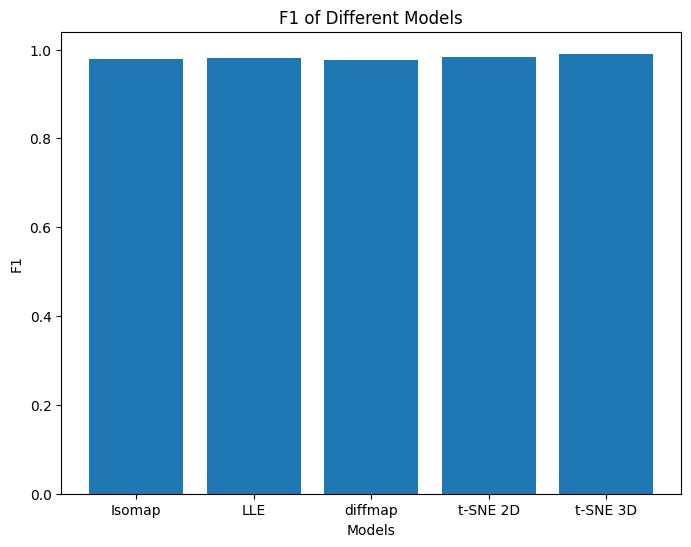

In [ ]:
for key in list(results_dict.values())[0].keys():
  PlotResult(results_dict, key)

## Print Results as Table

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(results_dict, orient='index')

print(df)

          Accuracy  Precision    Recall        F1
Isomap    0.978750   0.979032  0.978750  0.978682
LLE       0.981250   0.981346  0.981250  0.981159
diffmap   0.976250   0.976680  0.976250  0.976162
t-SNE 2D  0.983750   0.983741  0.983750  0.983744
t-SNE 3D  0.990625   0.990667  0.990625  0.990591


# Naive Bayes

## Fit Model

In [ ]:
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=4)
}

results_dict = evaluateClassification(X_dict, y, GaussianNB, param_grid)

Best Parameters for Isomap: {'var_smoothing': 0.001}
Best Parameters for LLE: {'var_smoothing': 0.001}
Best Parameters for diffmap: {'var_smoothing': 0.001}
Best Parameters for t-SNE 2D: {'var_smoothing': 0.001}
Best Parameters for t-SNE 3D: {'var_smoothing': 0.001}


## Plot Results

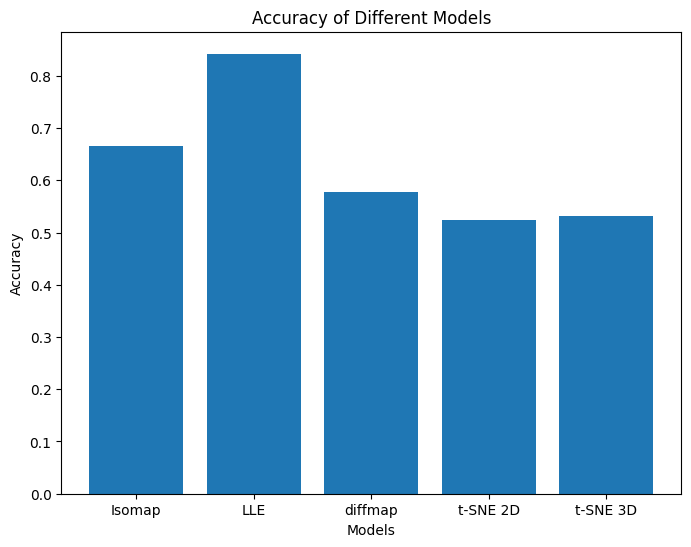

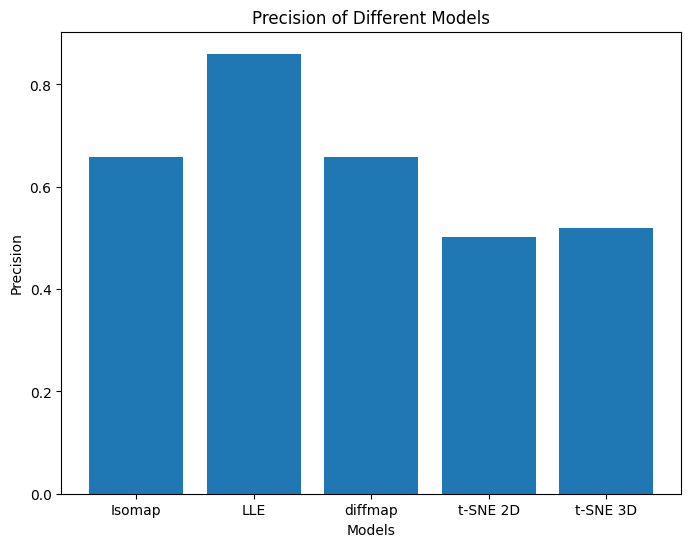

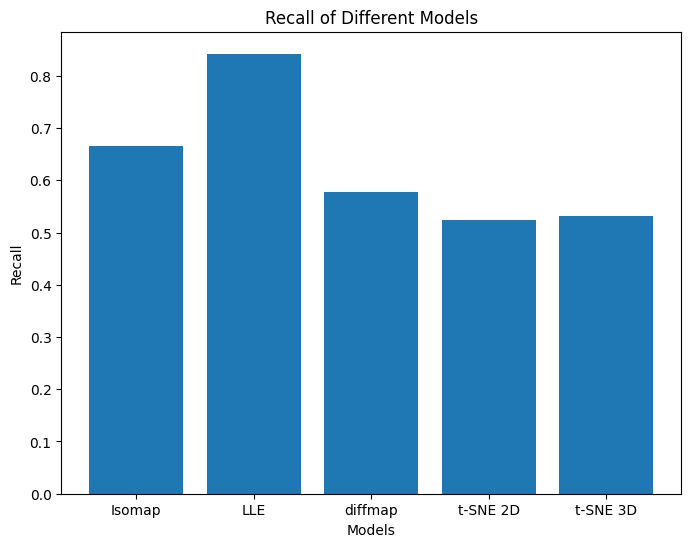

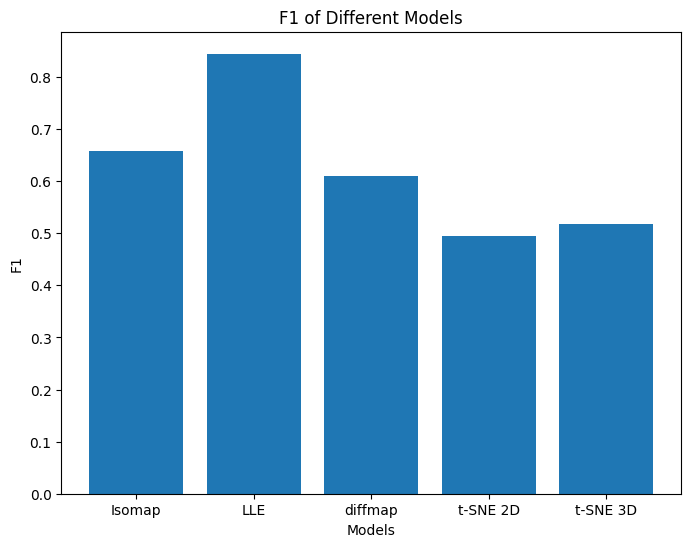

In [ ]:
for key in list(results_dict.values())[0].keys():
  PlotResult(results_dict, key)

## Print Results as Table

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(results_dict, orient='index')

print(df)

          Accuracy  Precision    Recall        F1
Isomap    0.665000   0.658070  0.665000  0.657381
LLE       0.842500   0.860004  0.842500  0.844452
diffmap   0.577500   0.658354  0.577500  0.609639
t-SNE 2D  0.524375   0.502542  0.524375  0.494489
t-SNE 3D  0.531875   0.519799  0.531875  0.517204


# k-nearest Neighbors (KNN)

## Fit Model

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance']
}

results_dict = evaluateClassification(X_dict, y, KNeighborsClassifier, param_grid)

Best Parameters for Isomap: {'n_neighbors': 3, 'weights': 'distance'}
Best Parameters for LLE: {'n_neighbors': 3, 'weights': 'distance'}
Best Parameters for diffmap: {'n_neighbors': 3, 'weights': 'distance'}
Best Parameters for t-SNE 2D: {'n_neighbors': 3, 'weights': 'distance'}
Best Parameters for t-SNE 3D: {'n_neighbors': 3, 'weights': 'distance'}


## Plot Results

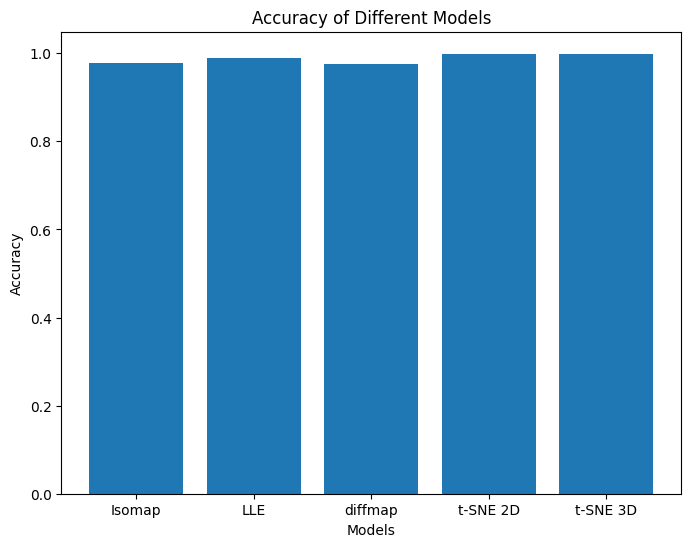

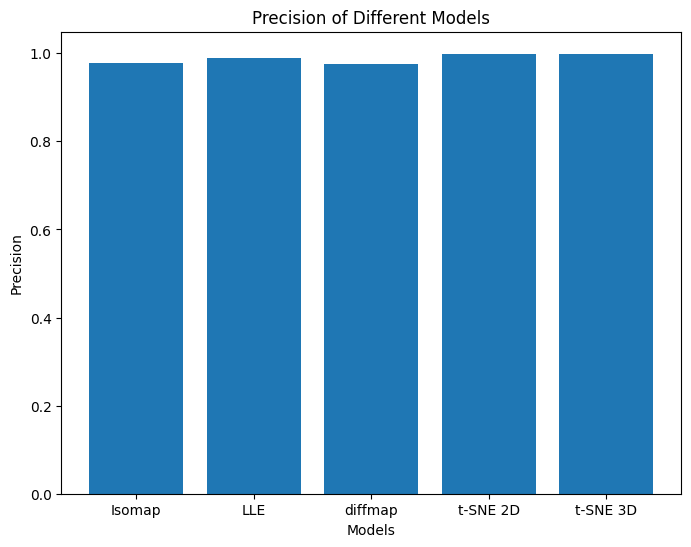

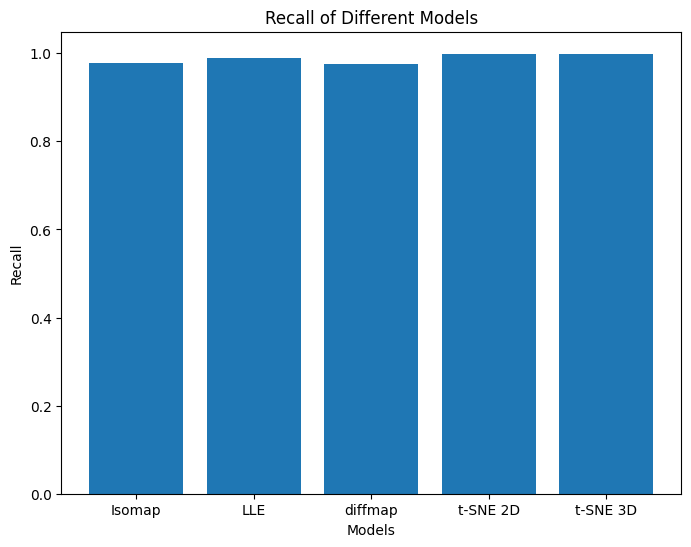

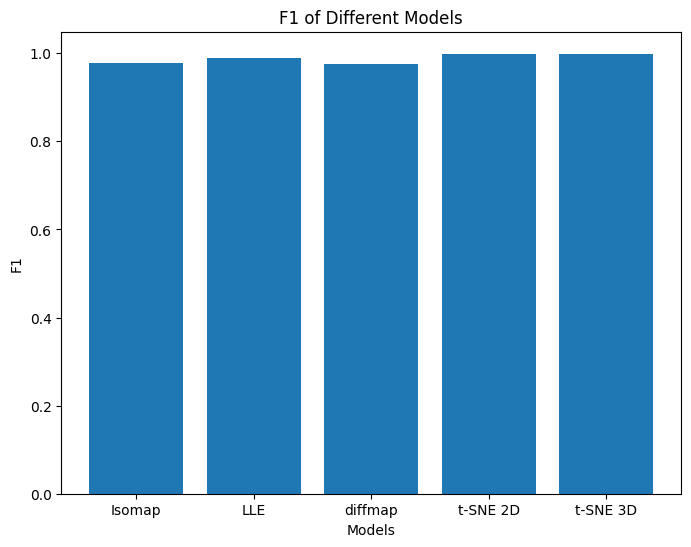

In [ ]:
for key in list(results_dict.values())[0].keys():
  PlotResult(results_dict, key)

## Print Results as Table

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(results_dict, orient='index')

print(df)

          Accuracy  Precision    Recall        F1
Isomap    0.978750   0.978822  0.978750  0.978669
LLE       0.988750   0.988792  0.988750  0.988721
diffmap   0.975625   0.975639  0.975625  0.975601
t-SNE 2D  0.998750   0.998755  0.998750  0.998750
t-SNE 3D  0.998750   0.998755  0.998750  0.998750
